In [ ]:
import pandas as pd

background = pd.read_csv('../data/background-clean.csv')
interest = pd.read_csv('../data/interest-clean.csv')
merge = pd.merge(background, interest, on='response_id', how='left')

merge.dom_y = merge.dom_y.str.split(';')
merge = merge.explode('dom_y')

I am curious on if it is possible to predict a student's project preference based on their programming language preference. Particularly, I am curious about predicting the project's domain. To accomplish this, I first visualized histograms of student's domain preferences.

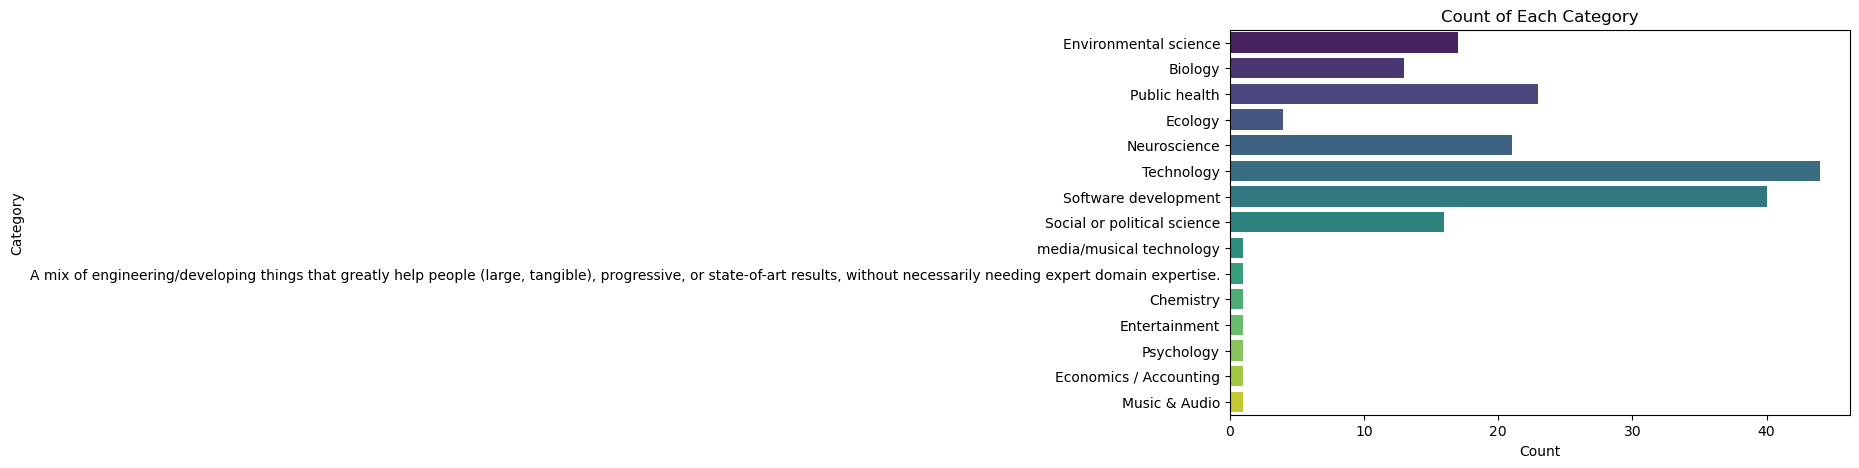

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a countplot
plt.figure(figsize=(8, 5))
sns.countplot(y='dom_y', data=merge, palette='viridis') # 'x' specifies the categorical column
plt.title('Count of Each Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

There are a ton of categories, so I collapsed them into two main categories: science (e.g. biology, chemistry, etc.) or technology (e.g. software development, music & audio, etc.). 

In [ ]:
dom_map = {'Environmental science': 'science', 'Biology': 'science', 'Public health': 'science', 'Ecology': 'science',
'Neuroscience': 'science', 'Psychology': 'science', 'Chemistry': 'science',

'Technology': 'tech', 'Software development': 'tech', 'media/musical technology':'tech', 'Music & Audio': 'tech',
'Social or political science':'science', 'Entertainment':'tech','Economics / Accounting': 'science'


}

merge['domain'] = merge['dom_y'].map(dom_map)
merge['domain']

0     science
0     science
0     science
1     science
1     science
       ...   
48       tech
49    science
49    science
50       tech
50       tech
Name: domain, Length: 187, dtype: object

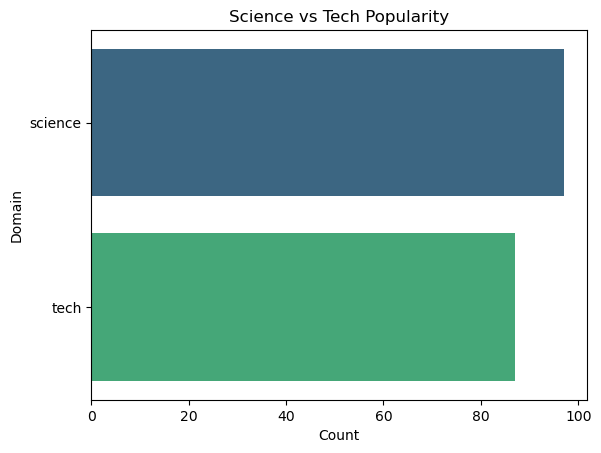

In [14]:
sns.countplot(y='domain', data=merge, palette='viridis')
plt.title('Science vs Tech Popularity')
plt.xlabel('Count')
plt.ylabel('Domain')
plt.show()

Then, I plotted the popularity of the domains by the programming language preferences. While Python is the most popular, within Python-fluent students, students are more interested in technology projects. The majority of students preferring R are more interested in science, on the other hand, and same for students with no preference. This makes sense because Python is more popular in the technology industry, whereas life sciences research more commonly uses R. 

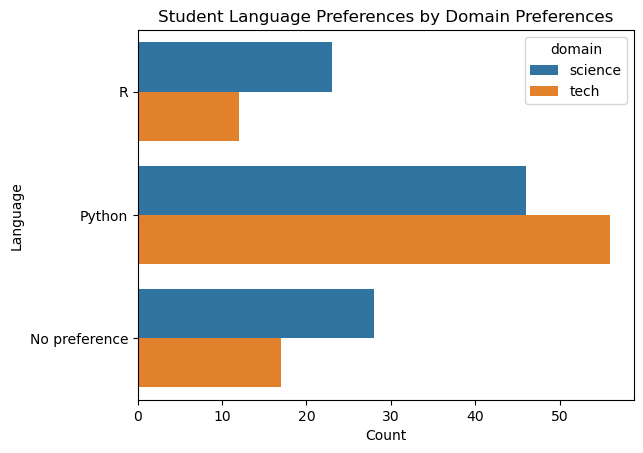

In [20]:
sns.countplot(y='lang', data=merge[merge['lang'].isin(['R', 'Python', 'No preference'])], hue='domain')
plt.xlabel('Count')
plt.ylabel('Language')
plt.title('Student Language Preferences by Domain Preferences')
plt.show()

I wanted to run a logistic regression model. First, I filtered the data to only have students who have a preference between R and Python. I set the default to R and science and ran a model:

log(p/(1-p)) = b0 + b1x1

Where log(p/(1-p)) represents the log odds of a student preferring technology. b0 represents the log odds of an R-fluent student  preferring a technology project, and b1 represents the relative increase in log odds for a Python-fluent student.

Based on the output, b0 = -.46, b1 = .51, it is unlikely for an R-fluent student to prefer a technology project, whereas a Python-fluent student prefers a technology project. This matches up with our data visualization. The accuracy is 0.66, which also makes sense, because students are still fairly split between science and technology domains. 

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Prepare the dataset
df_filtered = merge[merge['lang'].isin(['R', 'Python'])]
df_filtered = df_filtered[df_filtered['domain'].isin(['science', 'tech'])]

lang_map = {'R': 0, 'Python': 1}
domain_map = {'science': 0, 'tech': 1}

df_binarized = df_filtered
df_binarized['domain'] = df_binarized['domain'].map(domain_map)
df_binarized['lang'] = df_binarized['lang'].map(lang_map)
df_binarized[['domain', 'lang']]

# 2. Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.array(df_binarized['lang']).reshape(-1, 1), df_binarized['domain'], test_size=0.3, random_state=42)

# 3. Create and train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# 4. Make predictions on the test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Optional: Get coefficients and intercept
print(f"Coefficient: {model.coef_[0][0]:.2f}")
print(f"Intercept: {model.intercept_[0]:.2f}")

Model Accuracy: 0.64
Coefficient: 0.51
Intercept: -0.46
